In [1]:
import os
import sys
from pathlib import Path
import warnings
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import yaml
import importlib
import numpy as np
import gvar as gv
import platform
import pprint
cwd = Path(os.getcwd())
# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)
# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels
# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

# local imports 
import xpt.fit_analysis as xfa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.plots as plots
warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')


/home/gmoney/lqcd/hyperon-xpt-master


In [2]:
from importlib import reload
importlib.reload(xfa)
importlib.reload(i_o)
importlib.reload(fit)
importlib.reload(priors)

<module 'xpt.priors' from '/home/gmoney/lqcd/hyperon-xpt-master/xpt/priors.py'>

In [3]:
# Define paths and other variables
if platform.system() == 'Darwin':
    base_dir = '/Users/grantdb/lqcd/hyperon-xpt-master'
else:
    base_dir = '/home/gmoney/lqcd/hyperon-xpt-master'

data_dir = os.path.join(base_dir, "data")
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
# bs_data_file = os.path.join(data_dir, "hyperon_bs_data.h5")
t_plot_min = 0
t_plot_max = 40
prior = priors.get_prior(units='mev')
input_output = i_o.InputOutput()
data, ensembles = input_output.get_data(units='phys')
new_prior = input_output.make_prior(data=data,prior=prior)
phys_point_data = input_output.get_data_phys_point()
print(ensembles)

['a06m310L', 'a09m135', 'a09m220', 'a09m310', 'a09m350', 'a09m400', 'a12m130', 'a12m220L', 'a12m310', 'a12m350', 'a12m400', 'a15m135XL', 'a15m220', 'a15m310', 'a15m310L', 'a15m350', 'a15m400']


In [11]:
def plot_params(fit,yparam,xparam=None):
    if xparam is None:
        xparam = 'eps2_a'
    colormap = {
        'a06' : '#6A5ACD',
        'a09' : '#51a7f9',
        'a12' : '#70bf41',
        'a15' : '#ec5d57',
    }
    x = {}
    y = {}
    baryon_latex = {
                'sigma': '\Sigma',
                'sigma_st': '\Sigma^*',
                'xi': '\Xi',
                'xi_st': '\Xi^*',
                'lambda': '\Lambda'
            }

    for i in range(len(ensembles)):
        for j, param in enumerate([xparam, yparam]):
            if param in baryon_latex.keys():
                value = fit.y[yparam][i]
                latex_baryon = baryon_latex[param]
                label = f'$m_{{{latex_baryon}}}$(MeV)'
            if param =='eps2_a':
                value = data['eps2_a'][i] 
                label = '$\epsilon_a^2$'
            if param == 'm_pi_sq':
                value = data['m_pi']**2[i] 
                label = '$m_\pi^2$'
            if j == 0:
                x[i] = value
                xlabel = label
            elif j == 1:
                y[i] = value
                ylabel = label
    added_labels = set()

    for i in range(len(ensembles)):
        C = gv.evalcov([x[i], y[i]])
        eVe, eVa = np.linalg.eig(C)
        color_key = ensembles[i][:3]
        color = colormap[color_key]
        label = f'{color_key.lower()}'

        for e, v in zip(eVe, eVa.T):
            plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                    [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
                        alpha=1.0, lw=2, color=color)

            if label not in added_labels:
                plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                        marker='o', mec='w', zorder=3, color=color, label=label)
                added_labels.add(label)
            else:
                plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                        marker='o', mec='w', zorder=3, color=color)
        

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
        ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
    plt.grid()
    plt.xlabel(xlabel, fontsize = 24)
    plt.ylabel(ylabel, fontsize = 24)
    if yparam ==   'xi':
        phys_point_yparam = gv.mean(np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']]))
    elif yparam == 'xi_st':
        phys_point_yparam = gv.mean(np.mean([gv.gvar(g) for g in ['1531.80(32)', '1535.0(0.6)']]))
    elif yparam == 'lambda':
        phys_point_yparam = gv.mean(gv.gvar(1115.683, 0.006))
    elif yparam == 'sigma':
        phys_point_yparam =  np.mean([gv.gvar(g) for g in ['1189.37(07)', '1192.642(24)', '1197.449(30)']]),
    elif yparam == 'sigma_st':
        phys_point_yparam = np.mean([gv.gvar(g) for g in ['1382.80(35)', '1383.7(1.0)', '1387.2(0.5)']])
    phys_point_xparam = 0.0
    if yparam in baryon_latex.keys():
        latex_baryon = baryon_latex[param]
        label = f'$m_{{{latex_baryon}}}$'
    plt.plot(phys_point_xparam, phys_point_yparam, marker='o', color='black', zorder=4)
    plt.axvline(phys_point_xparam, ls='--', color='black', label=label)

    fig = plt.gcf()
    plt.show()
    plt.close()
    return fig 


{
    'm_{xi,0}': 1327(21),
    's_{xi}': 1.22(53),
    'b_{xi,4}': 0.2(1.9),
    'd_{xi,a}': -0.67(19),
    'd_{xi,aa}': 1.35(26),
    'd_{xi,al}': -3.4(1.2),
    'g_{xi,xi}': 0.009(3.976),
    'g_{xi_st,xi}': 0.1(2.4),
    'm_{xi_st,0}': 1529(29),
    'a_{xi,4}': -0.8(1.7),
    's_{xi,bar}': 1.57(64),
    'b_{xi_st,4}': 0.6(4.4),
    'd_{xi_st,a}': -0.08(23),
    'd_{xi_st,aa}': 0.12(82),
    'd_{xi_st,al}': -4.0(1.3),
    'g_{xi_st,xi_st}': -0.4(1.6),
    'a_{xi_st,4}': -0.07(1.68),
    'eps2_a':
    array([0.029617(41), 0.065325(70), 0.066506(83), 0.06877(16), 0.06998(19),
           0.07161(20), 0.123785(95), 0.12594(12), 0.13008(23), 0.13214(20),
           0.13446(16), 0.19514(12), 0.19737(28), 0.20368(32), 0.20416(25),
           0.20707(48), 0.21167(56)], dtype=object),
    'm_pi':
    array([327.7(2.9), 134.5(1.1), 221.4(1.8), 318.5(2.6), 357.2(2.9),
           409.2(3.3), 132.3(1.0), 219.3(1.6), 308.2(2.3), 349.5(2.6),
           397.8(2.9), 134.68(90), 216.6(1.5), 309.9(2.1

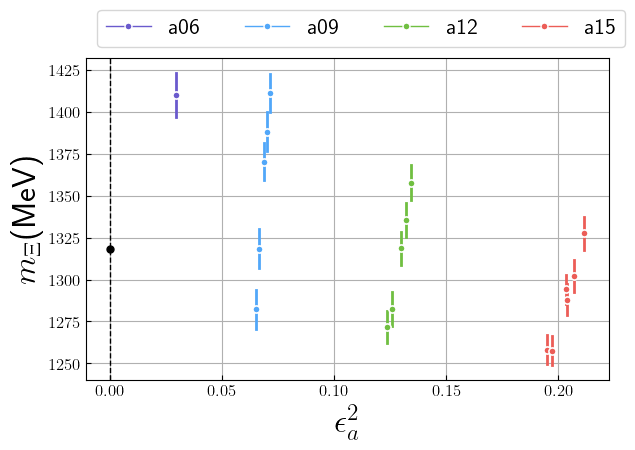

[0.0296175  0.04099609 0.05237468 0.06375328 0.07513187 0.08651047
 0.09788906 0.10926765 0.12064625 0.13202484 0.14340343 0.15478203
 0.16616062 0.17753922 0.18891781 0.2002964  0.211675  ]
1327(21)


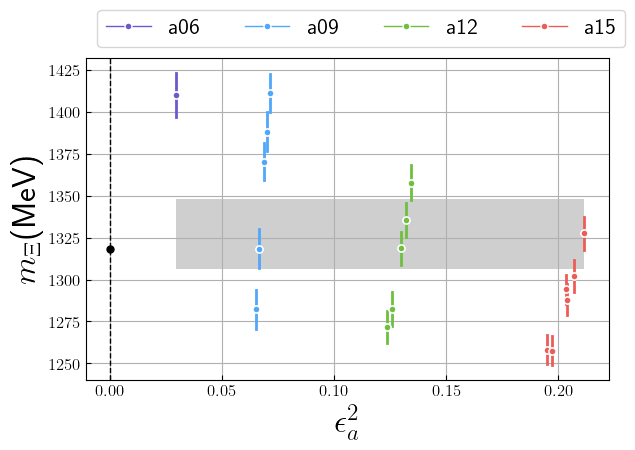

In [33]:
importlib.reload(xfa)
importlib.reload(fit)
importlib.reload(i_o)

with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
xi_models = models['models']['xi_system']
for mdl_key in xi_models:
    mdl_info = xi_models[mdl_key]
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
                                data=data,model_info=xi_models['xi:xi_st:d_n2lo:l_n2lo:x_n2lo'],prior=new_prior)
xi_sys_out = my_fit.fit
extrap_analysis = xfa.Xpt_Fit_Analysis(verbose=True,phys_point_data=phys_point_data,
                                data=data,model_info=mdl_info,prior=new_prior)

posterior = xi_sys_out.p
print(posterior)
yparam = 'xi'
def plot_fit():
    # plot data
    fig = plot_params(
        fit=xi_sys_out, 
        yparam='xi'
    )
    ax = fig.axes[0]
    min_max = lambda arr : (np.nanmin(arr), np.nanmax(arr))
    min_val, max_val = min_max(posterior['eps2_a'])
    # print(posterior['eps2_a'][0])
    eps2_a = np.linspace(gv.mean(min_val), gv.mean(max_val),num=17)
    # eps2_a = posterior['eps2_a']
    print(eps2_a)
    y = xi_sys_out.p['m_{xi,0}']
    print(y)
    pm = lambda g, k : gv.mean(g) + k *gv.sdev(g)
    ax.fill_between(gv.mean(eps2_a), pm(y, -1), pm(y, +1), facecolor='#A0A0A0', alpha=0.5, label='This fit')
    plt.close()
    return fig
plot_fit()

# pprint.pprint(extrap_analysis._extrapolate_to_ens())
# pprint.pprint(extrap_analysis.shift_latt_to_phys(phys_params=['xi']))
# xi_shift = {}
# eps2_a = {}
# x = {}
# # y = {}
# colors = {
#             '06' : '#6A5ACD',#'#00FFFF',
#             '09' : '#51a7f9',
#             '12' : '#70bf41',
#             '15' : '#ec5d57',
#         }
# for ens in ensembles:
#     x = xi_sys_out.p['eps2_a']
#     xi_shift = extrap_analysis.shift_latt_to_phys(phys_params=['xi'])
#     y = xi_shift
#     print(x,y)
#     eps2_a = xi_sys_out.p['eps2_a']
# # get xi_shift values in the same order as eps2_a
#     xi_shift_ordered = [xi_shift[ens] for ens in ensembles]
# # now calculate the covariance for each ensemble
#     for xi_shift_val, eps2_a_val, ens in zip(xi_shift_ordered, eps2_a, ensembles):
#         C = gv.evalcov([xi_shift_val, eps2_a_val])
#         eVe, eVa = np.linalg.eig(C)
#         for e, v in zip(eVe, eVa.T):
#             plt.plot([gv.mean(xi_shift_val)-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(xi_shift_val)],
#                     [gv.mean(eps2_a_val)-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(eps2_a_val)],
#                     color=colors[ens[1:3]], alpha=1.0, lw=2)
#             plt.plot(gv.mean(xi_shift_val), gv.mean(eps2_a_val), 
#                         color=colors[ens[1:3]], marker='o', mec='w', zorder=3)



## Xi, Xi* system SU(2) HBXPT extrapolation ##


In [6]:
posterior = {}
posterior.update(xi_sys_out.p)
# posterior.update(phys_point_data)
print(posterior)
print(extrap_analysis.extrapolated_mass(posterior))

{'m_{xi,0}': 1327(21), 's_{xi}': 1.22(53), 'b_{xi,4}': 0.2(1.9), 'd_{xi,a}': -0.67(19), 'd_{xi,aa}': 1.35(26), 'd_{xi,al}': -3.4(1.2), 'g_{xi,xi}': 0.009(3.976), 'g_{xi_st,xi}': 0.1(2.4), 'm_{xi_st,0}': 1529(29), 'a_{xi,4}': -0.8(1.7), 's_{xi,bar}': 1.57(64), 'b_{xi_st,4}': 0.6(4.4), 'd_{xi_st,a}': -0.08(23), 'd_{xi_st,aa}': 0.12(82), 'd_{xi_st,al}': -4.0(1.3), 'g_{xi_st,xi_st}': -0.4(1.6), 'a_{xi_st,4}': -0.07(1.68), 'eps2_a': array([0.029617(41), 0.065325(70), 0.066506(83), 0.06877(16), 0.06998(19),
       0.07161(20), 0.123785(95), 0.12594(12), 0.13008(23), 0.13214(20),
       0.13446(16), 0.19514(12), 0.19737(28), 0.20368(32), 0.20416(25),
       0.20707(48), 0.21167(56)], dtype=object), 'm_pi': array([327.7(2.9), 134.5(1.1), 221.4(1.8), 318.5(2.6), 357.2(2.9),
       409.2(3.3), 132.3(1.0), 219.3(1.6), 308.2(2.3), 349.5(2.6),
       397.8(2.9), 134.68(90), 216.6(1.5), 309.9(2.1), 306.8(2.1),
       347.7(2.3), 397.4(2.7)], dtype=object), 'lam_chi': array([1320(12), 1158.6(9.7), 12

In [9]:
def plot_fit(data,yparam, phys_point_data, posterior, ensembles):

    # shift data to physical masses

    # p.update(
    #     {
    #         # 'eps_pi' : phys_point_data['eps_pi'],
    #         'eps2_a' : phys_point_data['eps2_a']
    #     }
    # )
    y_fit = extrap_analysis.fitfcn(p=posterior)
    y_lattice = xi_sys_out.y[yparam]        
    y_fit_phys = extrap_analysis.fitfcn(p=posterior)

    y_shift = y_lattice + y_fit_phys[yparam] - y_fit[yparam]
    
    # plot data
    fig = plot_params(
        fit=xi_sys_out, 
        yparam='xi'
    )
    # plot fit band
    ax = fig.axes[0]
    # p.update(phys_point_data)
    # print(posterior)
    # p.update({'eps2_a' : np.linspace(0, 0.2)})
    min_max = lambda arr : (np.nanmin(arr), np.nanmax(arr))
    min_val, max_val = min_max(data['eps2_a'])
    print(posterior['eps2_a'][0])
    eps2_a = np.linspace(posterior['eps2_a'][0],posterior['eps2_a'][16])
    # eps2_a = posterior['eps2_a']
    print(eps2_a)
    y = extrap_analysis.fitfcn(p=posterior)
    pm = lambda g, k : gv.mean(g) + k *gv.sdev(g)
    ax.fill_between(gv.mean(eps2_a), pm(y[yparam], -1), pm(y[yparam], +1), facecolor='#A0A0A0', alpha=0.5, label='This fit')

    # # show CalLat result
    # ax.axvspan(0, 0, color='k', alpha=0.2)
    # ax.errorbar(
    #     x=0, 
    #     xerr=0,
    #     y=1.1964,
    #     yerr=0.0044,
    #     marker='o', color='k', capsize=0.0, mec='white', label='CalLat 2020')

    ax.legend()
    plt.close()
    return fig


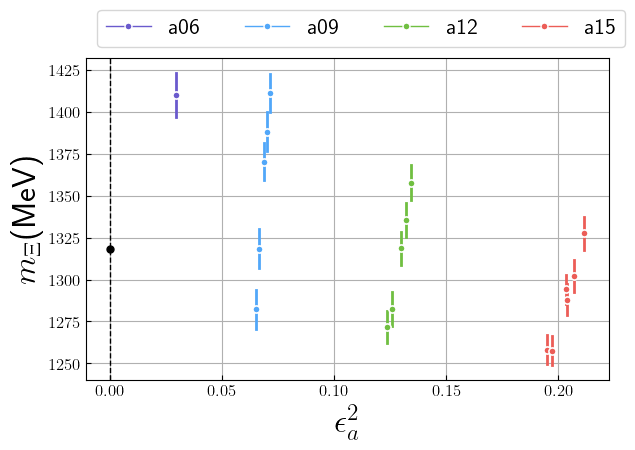

0(0)


TypeError: Cannot interpret '0(0)' as a data type

In [10]:
plot_fit( 
    data=data, 
    yparam='xi',
    phys_point_data=phys_point_data, 
    posterior=xi_sys_out.p, 
    ensembles=ensembles)

In [ ]:
def plot_fit(fit,param,observable, show_legend=True, ylim=None):
    x = {}
    y = {}
    c = {}

    plt.axes([0.145,0.145,0.85,0.85])
    colors = {
        '06' : '#6A5ACD',#'#00FFFF',
        '09' : '#51a7f9',
        '12' : '#70bf41',
        '15' : '#ec5d57',
    }
    latt_spacings = ['a06', 'a09' , 'a12', 'a15']

    for j, xx in enumerate(reversed(latt_spacings)):
        xx = xx[1:]
        xi = {}
        phys_data = phys_point_data
        phys_data['a'] = latt_spacings[j]

        min_max = lambda mydict : (gv.mean(np.nanmin([mydict[key] for key in mydict.keys()])), 
                                    gv.mean(np.nanmax([mydict[key] for key in mydict.keys()])))

        if param == 'eps_a':
            plt.axvline(0, label='phys. point', ls='--')
            # if model_info['eps2a_defn'] == 'w0_imp':
            eps2_a_arr = [fit.p['eps2_a']] 
            xi['eps_a'] = np.linspace(0, gv.mean(np.max(eps2_a_arr)))
            x_fit = xi['eps_a']

            
        # y_fit = fitfcn(posterior=posterior, fit_data=phys_data)
        y_fit = fit.y[observable]

        # For LO fits
        if not hasattr(y_fit, "__len__"):
            y_fit = np.repeat(y_fit, len(x_fit))

        pm = lambda g, k : gv.mean(g) + k *gv.sdev(g)
        if xx != '00' and param != 'a':
            plt.fill_between(pm(x_fit, 0), pm(y_fit, -1), pm(y_fit, +1), color=colors[xx], alpha=0.4)
        elif xx == '00' and param != 'w0mO':
            plt.fill_between(pm(x_fit, 0), pm(y_fit, -1), pm(y_fit, +1), facecolor='None', edgecolor='k', alpha=0.6, hatch='/')
        else:
            pass

    for ens in ensembles:
        if param == 'a':
            x[ens] = fit.p['eps2_a']
            label = r'$\epsilon^2_a = (a / 2 w_{0,\mathrm{orig}})^2$'
        # return value_shifted
        y[ens] = extrap_analysis.shift_latt_to_phys(ens=ens,phys_params=['xi'])
            #label = '$\epsilon^2_a = (a / 2 w_0)^2$'

    for ens in reversed(ensembles):
        print(x[ens],y[ens])
        C = gv.evalcov([x[ens], y[ens]])
        eVe, eVa = np.linalg.eig(C)
        for e, v in zip(eVe, eVa.T):
            plt.plot([gv.mean(x[ens])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[ens])],
                    [gv.mean(y[ens])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[ens])],
                    color=colors[ens[1:3]], alpha=1.0, lw=2)
            plt.plot(gv.mean(x[ens]), gv.mean(y[ens]), 
                        color=colors[ens[1:3]], marker='o', mec='w', zorder=3)

    if show_legend:
        if param == 'a':
            labels = [
                r'$a_{06}(l_F^{\rm phys},s_F^{\rm phys})$',
                r'$a_{09}(l_F^{\rm phys},s_F^{\rm phys})$',
                r'$a_{12}(l_F^{\rm phys},s_F^{\rm phys})$',
                r'$a_{15}(l_F^{\rm phys},s_F^{\rm phys})$'
            ]
        handles = [
            plt.errorbar([], [], 0, 0, marker='o', capsize=0.0, mec='white', mew=2.0, ms=8.0, elinewidth=3.0, color=colors['06']),
            plt.errorbar([], [], 0, 0, marker='o', capsize=0.0, mec='white', mew=2.0, ms=8.0, elinewidth=3.0, color=colors['09']),
            plt.errorbar([], [], 0, 0, marker='o', capsize=0.0, mec='white', mew=2.0, ms=8.0, elinewidth=3.0, color=colors['12']),
            plt.errorbar([], [], 0, 0, marker='o', capsize=0.0, mec='white', mew=2.0, ms=8.0, elinewidth=3.0, color=colors['15'])
        ]
        plt.legend(handles=handles, labels=labels, ncol=2)#, bbox_to_anchor=(0,1), loc='lower left')

    #plt.grid()
    plt.xlabel(label)

    if observable == 'xi':
        plt.ylabel('$m_\Xi$')
    elif observable == 't0':
        plt.ylabel('$m_\Omega \sqrt{t_0 / a^2}$')

    if ylim is not None:
        plt.ylim(ylim)

    fig = plt.gcf()
    plt.close()
    return fig



[0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0) 0(0)
 0(0) 0(0) 0(0)] 1327.5(9.8)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

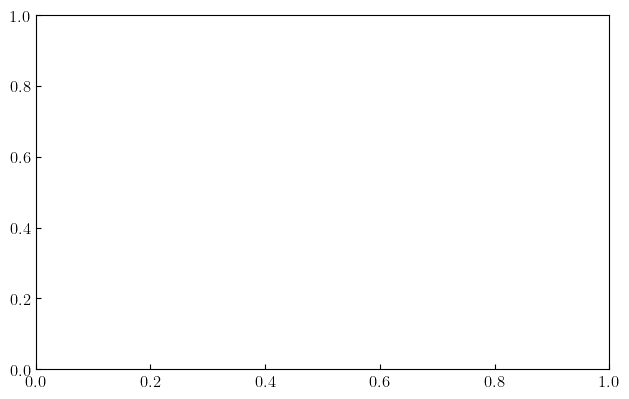

In [ ]:
# for param in ['xi','xi_st']:
    # plot_params(fit=xi_sys_out,yparam=param)
plot_fit(fit=xi_sys_out,param='a',observable='xi')


In [ ]:
from scipy.interpolate import interp1d
importlib.reload(xfa)

def perform_fit_and_plot(model_type,mdl_key):
    mdl_info = model_type[mdl_key]
    extrap_analysis = xfa.fit_analysis(verbose=False, phys_point_data=phys_point_data,
                                data=data, model_info=mdl_info, prior=new_prior)
    fit_out = extrap_analysis.fit
    print(fit_out)
    print(f"Model: {mdl_key}")
    print(extrap_analysis)

    # x_data = [gv.mean(x) for x in extrap_analysis.fit.p['eps2_a']]
    # for part in mdl_info['particles']:
    #     y_data = [gv.mean(y) for y in extrap_analysis.fit.y[part]]

    # y_fit = interp1d(x_data, y_data, kind='cubic', fill_value='extrapolate')

    # x_fit = np.linspace(-0.1, 0.1, 100)
    # y_fit_vals = [y_fit(x) for x in x_fit]

    # plt.plot(x_fit, y_fit_vals, label=f"{mdl_key}")
    # plt.fill_between(x_fit, [y - gv.sdev(y) for y in y_fit_vals], [y + gv.sdev(y) for y in y_fit_vals], alpha=0.5)

    # plt.axvline(0, ls='--', color='black', label='phys. point')
    # y_phys = np.mean([gv.gvar(g) for g in ['1314.86(20)', '1321.71(07)']])
    
    # plt.plot(0, gv.mean(y_phys), marker='o', mec='w', zorder=0.2, color='black')

    # plt.xlabel("$\epsilon_a^2$")
    # plt.ylabel("$m_\Xi(MeV)$")
    # plt.legend()
    # plt.grid()
    # plt.show()
    return fit_out


In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    try:
        perform_fit_and_plot(lam_sig_models,mdl_key)
    except Exception as e:
        print(f"Error encountered for Model: {mdl_key}")
        print(f"Error details: {e}")
        continue
    

Error encountered for Model: lam:sigma:sigma_st:l_lo:d_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_n2lo:d_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_n2lo:d_n2lo:x_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_nlo:d_n2lo:x_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_lo:d_n2lo:s_lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_n2lo:d_n2lo:s_lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Model: lam:sigma:sigma_st:l_nlo:s_lo:d_n2lo:x_n2lo
Error details: module 'xpt.fit_analysis' has no attribute 'fit_analysis'
Error encountered for Mod

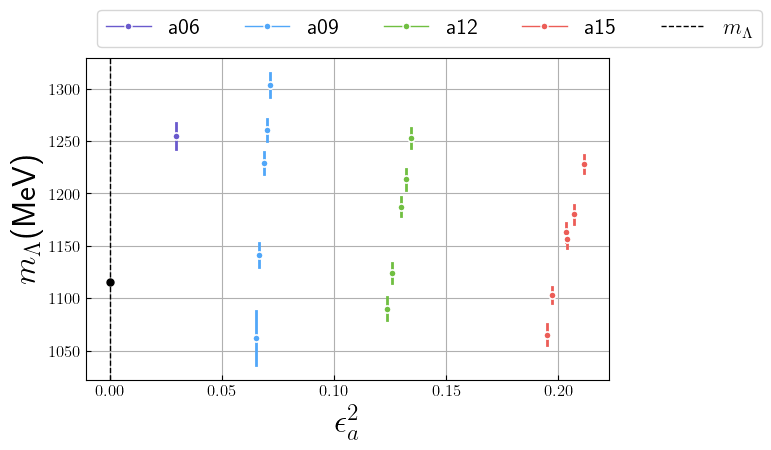

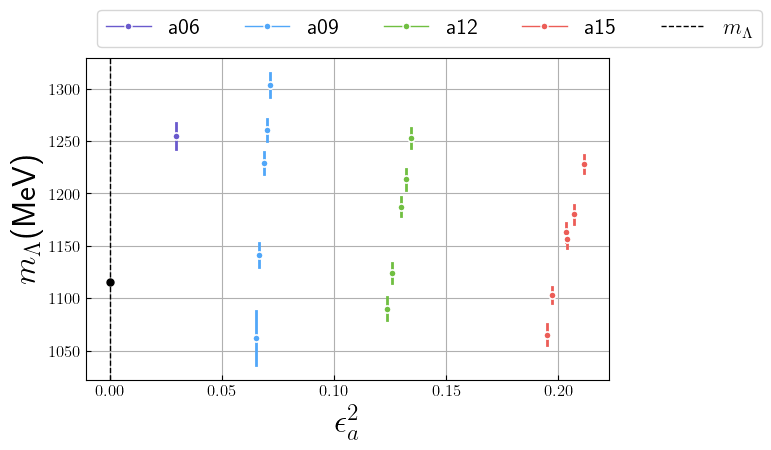

In [ ]:
lam_sig_models = models['models']['lam_sigma_system']
model_info = lam_sig_models['lam:sigma:sigma_st:l_lo:d_n2lo:s_lo']
my_fit = fit.FitRoutine(phys_point_data=phys_point_data,emp_bayes=None,empbayes_grouping=None,
                                data=data,model_info=model_info,prior=new_prior)
lam_sigma_sys_out = my_fit.fit
plot_params(fit=lam_sigma_sys_out,yparam='lambda')

In [ ]:
lam_sigma_fit = perform_fit_and_plot(model_type=mod)
plot_params()

NameError: name 'mod' is not defined

### Lambda, Sigma, Sigma_star SU(2) hbxpt extrapolation

In [ ]:
with open('../xpt/models.yaml', 'r') as f:
    models = yaml.load(f, Loader=yaml.FullLoader)
lam_sig_models = models['models']['lam_sigma_system']
for mdl_key in lam_sig_models:
    perform_fit_and_plot(lam_sig_models,mdl_key)

Model: lam:sigma:sigma_st:l_n2lo:s_n2lo:d_n2lo:x_n2lo

---
Least Square Fit:
  chi2/dof [dof] = 0.99 [51]    Q = 0.49    logGBF = -247.67

Parameters:
         m_{lambda,0}         1039.01 +- 26.9751            [               1000 +- 50 ]  
           s_{lambda}          2.1043 +- 1.00877            [                   0 +- 5 ]  
         b_{lambda,4}        0.882997 +- 4.37478            [                   0 +- 5 ]  
         d_{lambda,a}      0.0539212 +- 0.312282            [                   0 +- 5 ]  
        d_{lambda,aa}       -0.149455 +- 1.18896            [                   0 +- 5 ]  
        d_{lambda,al}        -3.55825 +- 3.39301            [                   0 +- 5 ]  
         d_{lambda,s}       -1.02076 +- 0.783243            [                   0 +- 5 ]  
        d_{lambda,as}         4.15861 +- 3.30558            [                   0 +- 5 ]  
        d_{lambda,ls}          2.4444 +- 4.66278            [                   0 +- 5 ]  
        d_{lambda,ss}        -

KeyError: 'undefined key: a_{sigma,4}'